# Inspired and adapted from

https://nbviewer.org/github/ImadDabbura/blog-posts/blob/master/notebooks/Coding-Neural-Network-Forwad-Back-Propagation.ipynb

https://www.youtube.com/watch?v=V1uKU_8q2p8

https://github.com/Coding-Lane/Dropout-Regularization

https://github.com/Gelesh/DeepLearingVanilaCode/blob/main/Dropout_MoreData.ipynb

In [1]:
#
# Configure this notebook for your local setup
#

# Set to True to train cat_vs_not
CATS=False

# Local paths to CATS datasets
# Note you can download here: https://github.com/rvarun7777/Deep_Learning
CATS_TRAIN = "./NN/train_catvnoncat.h5"
CATS_TEST = "./NN/test_catvnoncat.h5"

# Set to True for digits
DIGITS=True

# Set to True for very verbose debugging
DEBUG=False

In [2]:
# 
# install any required packages with versions
#

!python3 -m pip install matplotlib==3.7.1
!python3 -m pip install h5py==3.8.0
!python3 -m pip install numpy==1.24.2
!python3 -m pip install scikit-learn==1.2.1

In [3]:
#
# Imports
#

# System imprts
import os 
import sys
import random

# Installed packages
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits

# Configure matplotlib
%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

# Configure seeds
random.seed(1)
np.random.seed(1)

<a id="Coding the NN"></a>

In [4]:
# Initialize parameters
def initialize_parameters(layers_dims):
    """
    Initialize parameters dictionary.
    
    Weight matrices will be initialized to random values from uniform normal
    distribution.
    bias vectors will be initialized to zeros.

    Arguments
    ---------
    layers_dims : list or array-like
        dimensions of each layer in the network.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)   
    random.seed(1)
    
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)

    return parameters

In [5]:
# Define activation functions that will be used in forward propagation
def sigmoid(Z):
    """
    Computes the sigmoid of Z element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    
    A = 1 / (1 + np.exp(-Z) + 1e-15)
    #print("AA", A, Z)

    return A, Z


def tanh(Z):
    """
    Computes the Hyperbolic Tagent of Z elemnet-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.tanh(Z)

    return A, Z


def relu(Z):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0, Z)

    return A, Z


def leaky_relu(Z):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0.1 * Z, Z)

    return A, Z

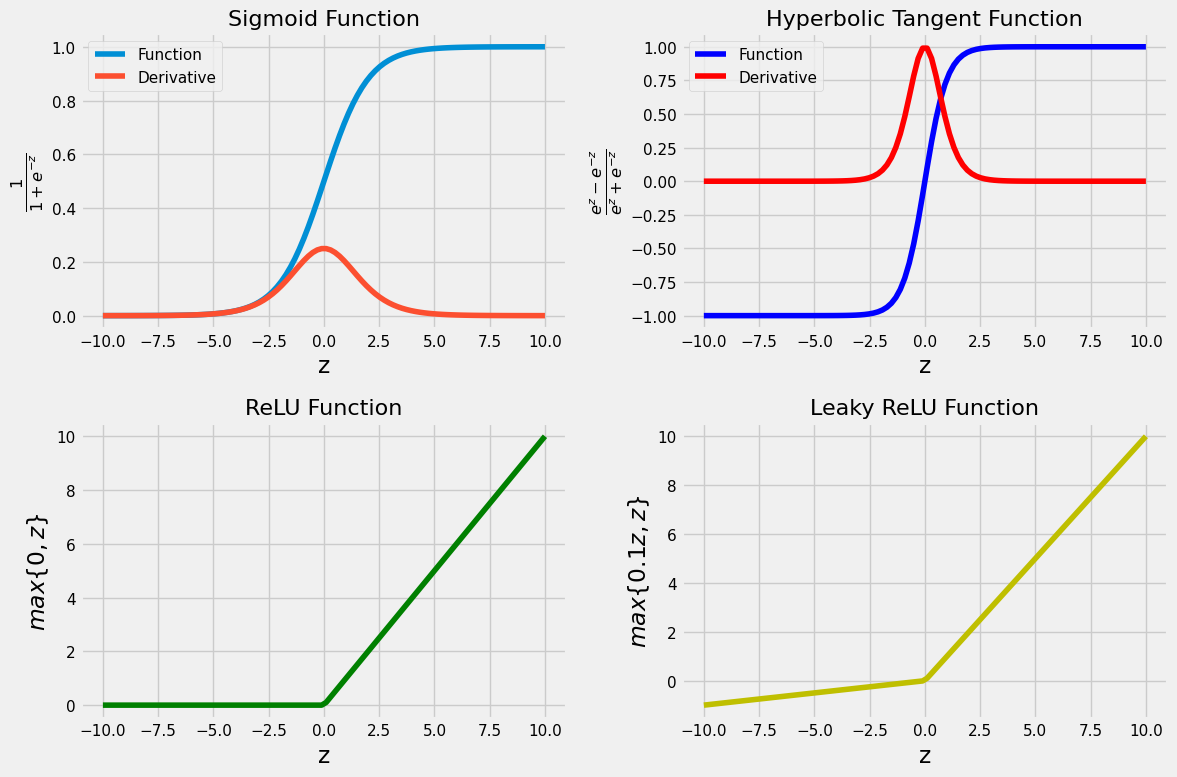

In [6]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label = "Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize = 16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize = 16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize = 16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize = 16)
plt.tight_layout();

In [7]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    """
    Computes affine transformation of the input.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.

    Returns
    -------
    Z : 2d-array
        affine transformation output.
    cache : tuple
        stores A_prev, W, b to be used in backpropagation.
    """
    Z = np.dot(W, A_prev) + b
    cache = [A_prev, W, b]

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    """
    Computes post-activation output using non-linear activation function.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.
    activation_fn : str
        non-linear activation function to be used: "sigmoid", "tanh", "relu".

    Returns
    -------
    A : 2d-array
        output of the activation function.
    cache : tuple
        stores linear_cache and activation_cache. ((A_prev, W, b), Z) to be used in backpropagation.
    """
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    # None for dropout
    cache = [linear_cache, activation_cache, None]

    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu",keepRate=1):
    """
    Computes the output layer through looping over all units in topological
    order.

    Arguments
    ---------
    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
    """
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    if DEBUG: print("Parameter Keys=", L, parameters.keys())
    
    drop_out = False
    if keepRate!=None and keepRate<1:
        drop_out = True
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)

        # previous drop out code
        # Dropout in all layers except the last layer.
        # Drop = np.random.rand(A.shape[0], A.shape[1])
        # Drop = Drop < keepRate
        # A = A * Drop
        # A = A/keepRate
        # cache[-1] = Drop
        # previous drop out code
        
        # new dropout code
        if drop_out:
            prob = 1 - keepRate
            mask = np.random.uniform(low=0., high=1., size=A.shape) > prob
            scale = 1.0 / (1 - prob )
            A = A * mask * scale
            #deltas = np.zeros(shape=A.shape)
            cache[-1] = (A.shape, mask, scale)      
            if DEBUG: print("Forward: CacheEntry(%d)=" % l, len(cache[-1]))
        # new dropout code
        
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn=hidden_layers_activation_fn)

    caches.append(cache)

    assert AL.shape == (1, X.shape[1])

    if DEBUG: print("Forward: Caches size=%d, summary=" % len(caches), \
          [ (c[-1][0],len(c[-1])) if c[-1] else c[-1] for c in caches ] )
    
    return AL, caches

In [8]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    """
    Computes the binary Cross-Entropy cost.

    Arguments
    ---------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    y : 2d-array
        true "label" vector.

    Returns
    -------
    cost : float
        binary cross-entropy cost.
    """
    m = y.shape[1]        
    
    AL += 1e-15 # avoid log(0)
    cost = - (1 / m) * np.sum(
            np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL))) 

    return cost

In [9]:
# Define derivative of activation functions w.r.t z that will be used in back-propagation
def sigmoid_gradient(dA, Z):
    """
    Computes the gradient of sigmoid output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    """
    Computes the gradient of hyperbolic tangent output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    """
    Computes the gradient of ReLU output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.

    Arguments
    ---------
    dZ : 2d-array
        gradient of the cost w.r.t. the linear output (of current layer l).
    cache : tuple
        values of (A_prev, W, b) coming from the forward propagation in the current layer.

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1).
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l).
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l).
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    """
    Arguments
    ---------
    dA : 2d-array
        post-activation gradient for current layer l.
    cache : tuple
        values of (linear_cache, activation_cache).
    activation : str
        activation used in this layer: "sigmoid", "tanh", or "relu".

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1), same shape as A_prev.
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l), same shape as W.
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l), same shape as b.
    """
    linear_cache, activation_cache,Drop = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu", keepRate=None):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "tanh", "relu".

    Returns
    -------
    grads : dict
        with the gradients.
    """
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}
    diviation = np.multiply(AL, 1 - AL)
    diviation = np.where(diviation==0,0.0000001,diviation) # Avoid Division by  Zero
    dAL = np.divide(AL - y, diviation)
    if DEBUG: print("Backward: dAL=", dAL.shape)

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], hidden_layers_activation_fn)
    if DEBUG: print("Backward:",\
                    "dA(%d)=" % (L-1), grads["dA" + str(L-1)].shape, \
                    "dW(%d)=" % L, grads["dW" + str(L)].shape, \
                    "dB(%d)=" % L, grads["db" + str(L)].shape )
    
    drop_out = False
    if keepRate!=None and keepRate<1:
        drop_out = True  
  
    # previous dropout code
    # Drop = caches[L-2][-1]
    # if Drop is not None:
    # grads["dA" + str(L - 1)] = grads["dA" + str(L - 1)]*Drop/keepRate 
    # previous dropout code
    
    # new dropout code
    if drop_out: 
        drop = caches[-2][-1] # get the drop out parms created during forward paass
        shape, mask, scale = drop   
        grads["dA" + str(L - 1)] = grads["dA" + str(L - 1)] * mask 
    # new dropout code 

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)
        if DEBUG: print("Backward(%d):" % l,\
                        "dA(%d)" % (l-1), \
                        "dW(%d)" % l, \
                        "dB(%d)" % l, \
                        "current_cache=",\
                        current_cache[-1][0] if current_cache[-1] else current_cache[-1] )

        # previous drop out code
        # if l > 1 :
        # Drop = caches[l-2][-1]
        # grads["dA" + str(l - 1)] = grads["dA" + str(l - 1)] #*Drop/keepRate 
        # previous drop out code         
        
        # new dropout code
        if drop_out and (l-2)>=0: 
            drop = caches[l-1][-1] # get the drop out parms created during forward paass
            shape, mask, scale  = drop
            grads["dA" + str(l)] = grads["dA" + str(l)] * mask   
        # new dropout code
            
    if DEBUG: print("Backward: Grads keys=", grads.keys())
    return grads


# define the function to update both weight matrices and bias vectors
def update_parameters(parameters, grads, learning_rate):
    """
    Update the parameters' values using gradient descent rule.

    Arguments
    ---------
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    grads : dict
        stores all gradients (output of L_model_backward).

    Returns
    -------
    parameters : dict
        updated parameters.
    """
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

<a id="Application"></a>

In [10]:
# Define the multi-layer model using all the helper functions we wrote before


def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=True, hidden_layers_activation_fn="relu",parameters=None,KeepRate=None,Silent=False):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test examples.
    """
    np.random.seed(1)
    random.seed(1)

    # initialize parameters
    if(parameters is None):
        parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []
    cost_list_Test = []
    error_list = []
    error_list_Test = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn,KeepRate)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn,KeepRate)
        
        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            #,y_test
            AL_Test, caches_Test = L_model_forward(
                X_test, parameters, hidden_layers_activation_fn)
            cost_Test = compute_cost(AL_Test, y_test)
            
            traiError = getError(X,      parameters, y,      hidden_layers_activation_fn)
            testError = getError(X_test, parameters, y_test, hidden_layers_activation_fn)

            if not Silent:
                print(f"The cost,Error after {i + 1} iterations is: {cost:.7f},{traiError:.7f} Test:{cost_Test:.7f},{testError:.7f}")
           
            cost_list.append(cost)
            cost_list_Test.append(cost_Test)
            error_list.append(traiError)
            error_list_Test.append(testError)


        if i % 100 == 0:
            cost_list.append(cost)
            if DEBUG: raise Exception("Debugging: Stop")
            
    if not Silent:
        # plot the cost curve
        # plot the cost curve
        plt.figure(figsize=(10, 6))
        plt.plot(cost_list)
        plt.plot(cost_list_Test)
        plt.xlabel("Iterations (per hundreds)")
        plt.ylabel("Loss")
        plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return (cost_list,cost_list_Test,error_list,error_list_Test),parameters



def accuracy(X, parameters, y, activation_fn="relu",typeOf="Training", silent=False):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100

    if not silent: print(f"{typeOf}% Accuracy = : {accuracy:.2f}%.")
    return accuracy
    
def getError(X, parameters, y, activation_fn="relu"):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    error = np.mean(np.abs(labels - y)) * 100
    #print(f"The Error rate is: {error:.4f}%.")

    return error

# Data = CATS vs NOT


In [11]:
if CATS:
    
    # Import training dataset
    train_dataset = h5py.File(CATS_TRAIN)
    X_train = np.array(train_dataset["train_set_x"])
    y_train = np.array(train_dataset["train_set_y"])

    test_dataset = h5py.File(CATS_TEST)
    X_test = np.array(test_dataset["test_set_x"])
    y_test = np.array(test_dataset["test_set_y"])

    # X_train = np.loadtxt('dataset/train_x.csv', delimiter = ',')
    # y_train = np.loadtxt('dataset/train_y.csv', delimiter = ',')
    # X_test = np.loadtxt('dataset/test_x.csv', delimiter = ',')
    # y_test = np.loadtxt('dataset/test_y.csv', delimiter = ',')

    # print the shape of input data and label vector
    print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
    Test: {X_test.shape}, {y_test.shape}""")

    # plot cat image
    plt.figure(figsize=(6, 6))
    plt.imshow(X_train[50])
    plt.axis("off");

    # Transform input data and label vector
    X_train = X_train.reshape(209, -1).T
    y_train = y_train.reshape(-1, 209)

    X_test = X_test.reshape(50, -1).T
    y_test = y_test.reshape(-1, 50)

    # standarize the data
    X_train = X_train / 255
    X_test = X_test / 255

    # MODIFIED CODE BELOW from JP:
    # y_train = y_train.reshape(1, y_train.shape[0])
    # y_test = y_test.reshape(1, y_test.shape[0])

    print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
    Test: {X_test.shape}, {y_test.shape}""")
    
    layers_dims = [X_train.shape[0], 35,20, 1]
    lr=0.05
    itrn=8500
    
    # no drop out
    progress,parameters = L_layer_model( \
        X_train, y_train, layers_dims, learning_rate=lr, num_iterations=itrn, \
        hidden_layers_activation_fn="sigmoid",KeepRate=1.0)
    
    print()
    accuracy(X_train, parameters, y_train, activation_fn="sigmoid",typeOf="Train")
    accuracy(X_test, parameters, y_test, activation_fn="sigmoid",  typeOf="Test")
    
    progress,parameters_drop = L_layer_model( \
        X_train, y_train, layers_dims, learning_rate=lr, num_iterations=itrn, \
        hidden_layers_activation_fn="sigmoid",KeepRate=0.8) 
    
    print()
    accuracy(X_train, parameters_drop, y_train, activation_fn="sigmoid",typeOf="Train")
    accuracy(X_test, parameters_drop, y_test, activation_fn="sigmoid",  typeOf="Test")

# Data = Digits

In [12]:
#!pip install tensorflow_datasets
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data

# Create target
y = digits.target
y = np.where(y==8,1,0) # Identify 8 or not-8
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

Original dimensions:
--------------------
Training: (1437, 64), (1437,)
Test: (360, 64), (360,)


In [13]:
X_train = X_train.reshape(1437, -1).T
y_train = y_train.reshape(-1, 1437)

X_test = X_test.reshape(360, -1).T
y_test = y_test.reshape(-1, 360)

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")


New dimensions:
---------------
Training: (64, 1437), (1, 1437)
Test: (64, 360), (1, 360)


Now, our dataset is ready to be used and test our neural network implementation. Let's first write **multi-layer model** function to implement gradient-based learning using predefined number of iterations and learning rate.

In [14]:
if DIGITS:
    
    digits = load_digits()
    X = digits.data

    # Create target
    y = digits.target
    y = np.where(y==8,1,0) # Identify 8 or not-8
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
    Test: {X_test.shape}, {y_test.shape}""")
    
    X_train = X_train.reshape(1437, -1).T
    y_train = y_train.reshape(-1, 1437)

    X_test = X_test.reshape(360, -1).T
    y_test = y_test.reshape(-1, 360)

    print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
    Test: {X_test.shape}, {y_test.shape}""")

    
    


Original dimensions:
--------------------
Training: (1437, 64), (1437,)
    Test: (360, 64), (360,)

New dimensions:
---------------
Training: (64, 1437), (1, 1437)
    Test: (64, 360), (1, 360)


In [15]:
if DIGITS:
    
    # define a set of experiments for no-drop out
    experiments = [ \
        { "layers": [X_train.shape[0], 20,10, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid" },
        { "layers": [X_train.shape[0], 40,10, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid" },
        { "layers": [X_train.shape[0], 60,20, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid" },
        { "layers": [X_train.shape[0], 100,20, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid" },
        { "layers": [X_train.shape[0], 200,40, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid" },
        { "layers": [X_train.shape[0], 200,80, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid" }
    ]
    
    # run the experiments and capture results
    results = {}
    for idx, exp in enumerate(experiments):
        layers_dims = exp["layers"]
        lr= exp["lr"]
        itrn = exp["itrn"]
        activation_fn = exp["afn"]
        
        # Run the experiment
        print("Running experiment (%d/%d)=" % (idx, len(experiments) ), exp)
        progress,parameters = L_layer_model( \
            X_train, y_train, layers_dims, learning_rate=lr, num_iterations=itrn,\
            hidden_layers_activation_fn="sigmoid",KeepRate=1.0,Silent=True)
        
        # Compute the accuracy
        train_acc = accuracy(X_train, parameters, y_train, activation_fn="sigmoid", silent=True)
        test_acc = accuracy(X_test, parameters, y_test, activation_fn="sigmoid",typeOf='Testing', silent=True)

        results[idx] = ( exp, progress, parameters, train_acc, test_acc )
        print("Results: train=%.2f, test=%.2f" % ( train_acc, test_acc) )
            
    print("#Summary Of No-DropOut Experiments:")
    print("#{: >40} {: >20} {: >20}".format(*["experiment","train_acc","test_acc"]))
    for idx in results.keys():
        exp = results[idx][0]
        exp_summary = "%s,%s,%d,%s" % \
            ( str(exp["layers"]), "%.2f" % exp["lr"], exp["itrn"], exp["afn"])
        train_acc = "%.2f" % results[idx][3]
        test_acc = "%.2f" % results[idx][4]   
        print("#{: >40} {: >20} {: >20}".format(*[ exp_summary, train_acc, test_acc ] ))
        
    # define a set of experiments for dropout
    experiments = [ \
        { "layers": [X_train.shape[0], 20,10, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.95 },
        { "layers": [X_train.shape[0], 20,10, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.9 },
        { "layers": [X_train.shape[0], 20,10, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.7 },
        { "layers": [X_train.shape[0], 20,10, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.5 },
        
        { "layers": [X_train.shape[0], 200,40, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.95 },
        { "layers": [X_train.shape[0], 200,40, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.9 },
        { "layers": [X_train.shape[0], 200,40, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.7 },
        { "layers": [X_train.shape[0], 200,40, 1], "lr": 0.05,"itrn": 8500, "afn":"sigmoid", "drop":0.5 },           
    ]

    # run the experiments and capture results
    results = {}
    for idx, exp in enumerate(experiments):
        layers_dims = exp["layers"]
        lr= exp["lr"]
        itrn = exp["itrn"]
        activation_fn = exp["afn"]
        keep_rate = exp["drop"]
        
        # Run the experiment
        print("Running experiment (%d/%d)=" % (idx, len(experiments) ), exp)
        progress,parameters = L_layer_model( \
            X_train, y_train, layers_dims, learning_rate=lr, num_iterations=itrn,\
            hidden_layers_activation_fn="sigmoid",KeepRate=keep_rate,Silent=True)
        
        # Compute the accuracy
        train_acc = accuracy(X_train, parameters, y_train, activation_fn="sigmoid", silent=True)
        test_acc = accuracy(X_test, parameters, y_test, activation_fn="sigmoid",typeOf='Testing', silent=True)

        results[idx] = ( exp, progress, parameters, train_acc, test_acc )
        print("Results: train=%.2f, test=%.2f" % ( train_acc, test_acc) )

    print("#Summary Of DropOut Experiments:")
    print("#{: >40} {: >10} {: >10} {: >10}".format(*["experiment","dropout", "train_acc","test_acc"]))
    for idx in results.keys():
        exp = results[idx][0]
        exp_summary = "%s,%s,%d,%s" % \
            ( str(exp["layers"]), "%.2f" % exp["lr"], exp["itrn"], exp["afn"])
        drop = exp["drop"]
        train_acc = "%.2f" % results[idx][3]
        test_acc = "%.2f" % results[idx][4]   
        print("#{: >40} {: >10} {: >10} {: >10}".format(*[ exp_summary, drop, train_acc, test_acc ] ))
        
#Summary Of No-DropOut Experiments:
#                              experiment            train_acc             test_acc
#      [64, 20, 10, 1],0.05,8500,sigmoid                99.93                99.17
#       [64, 40, 10, 1],0.05,8500,sigmoid                99.93                99.17
#       [64, 60, 20, 1],0.05,8500,sigmoid                99.93                98.33
#      [64, 100, 20, 1],0.05,8500,sigmoid                99.93                98.89
#      [64, 200, 40, 1],0.05,8500,sigmoid               100.00                98.89
#      [64, 200, 80, 1],0.05,8500,sigmoid               100.00                99.17
    
#Summary Of DropOut Experiments:
#                              experiment    dropout  train_acc   test_acc
#       [64, 20, 10, 1],0.05,8500,sigmoid       0.95      99.93      99.17
#       [64, 20, 10, 1],0.05,8500,sigmoid        0.9      99.86      99.17
#       [64, 20, 10, 1],0.05,8500,sigmoid        0.7      99.10      98.61
#       [64, 20, 10, 1],0.05,8500,sigmoid        0.5      96.24      96.94
#      [64, 200, 40, 1],0.05,8500,sigmoid       0.95      99.93      98.89
#      [64, 200, 40, 1],0.05,8500,sigmoid        0.9      99.93      98.89
#      [64, 200, 40, 1],0.05,8500,sigmoid        0.7      99.30      98.06
#      [64, 200, 40, 1],0.05,8500,sigmoid        0.5      97.01      96.67
    


Running experiment (0/6)= {'layers': [64, 20, 10, 1], 'lr': 0.05, 'itrn': 8500, 'afn': 'sigmoid'}
Results: train=99.93, test=99.17
Running experiment (1/6)= {'layers': [64, 40, 10, 1], 'lr': 0.05, 'itrn': 8500, 'afn': 'sigmoid'}
Results: train=99.93, test=99.17
Running experiment (2/6)= {'layers': [64, 60, 20, 1], 'lr': 0.05, 'itrn': 8500, 'afn': 'sigmoid'}
Results: train=99.93, test=98.33
Running experiment (3/6)= {'layers': [64, 100, 20, 1], 'lr': 0.05, 'itrn': 8500, 'afn': 'sigmoid'}
Results: train=99.93, test=98.89
Running experiment (4/6)= {'layers': [64, 200, 40, 1], 'lr': 0.05, 'itrn': 8500, 'afn': 'sigmoid'}
Results: train=100.00, test=98.89
Running experiment (5/6)= {'layers': [64, 200, 80, 1], 'lr': 0.05, 'itrn': 8500, 'afn': 'sigmoid'}
Results: train=100.00, test=99.17
#Summary Of No-DropOut Experiments:
#                              experiment            train_acc             test_acc
#       [64, 20, 10, 1],0.05,8500,sigmoid                99.93                99.17
#    